In [1]:
import pandas as pd
import fastf1
import matplotlib.pyplot as plt
session = fastf1.get_session(2022,1,'FP1')
session.load()

api         WARNING 	

NO CACHE! Api caching has not been enabled! 
	It is highly recommended to enable this feature for much faster data loading!
	Use `fastf1.Cache.enable_cache('path/to/cache/')`

core           INFO 	Loading data for Bahrain Grand Prix - Practice 1 [v2.3.0]
api            INFO 	Fetching driver list...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Fetching timing app data...
core           INFO 	Processing timing data...
api            INFO 	Fetching session status data...
api            INFO 	Fetching track status data...
c:\Users\Bartek\AppData\Local\Programs\Python\Python38-32\lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
c:\Users\Bartek\AppData\Local\Programs\Python\Python38-32\lib\site-packages

In [2]:

#remember to debug the unknowntyre

#normalize time to start at the session's start
lapsDataFrame = session.laps
sessionFirstLap = lapsDataFrame["LapStartDate"].to_list()[0]
sessionOutTime = lapsDataFrame["PitOutTime"].to_list()[0]
rcm = session.race_control_messages
for x in range(len(rcm["Flag"].to_list())):
    if rcm["Flag"].to_list()[x]=="GREEN":
        sessionStartTime = rcm["Time"].to_list()[x]
        break
helpDelta = sessionFirstLap-sessionStartTime
timeDelta = sessionOutTime-helpDelta


In [3]:
#add columns with corrected timestamps to dataframe
lapsDataFrame = lapsDataFrame.assign(CorrectedPitOutTime = lambda x:(x["PitOutTime"]-timeDelta))
lapsDataFrame = lapsDataFrame.assign(CorrectedTime = lambda x:(x["Time"]-timeDelta))
lapsDataFrame = lapsDataFrame.assign(CorrectedPitInTime = lambda x:(x["PitInTime"]-timeDelta))

In [4]:
redFlagBeginnings = []
redFlagEndings = []
redFlag = False
for x in range(len(rcm["Flag"].to_list())):
    if rcm["Flag"].to_list()[x] == "RED":
        redFlagBeginnings.append(rcm["Time"].to_list()[x])
        redFlag = True
    if redFlag and rcm["Flag"].to_list()[x]=="GREEN":
        redFlagEndings.append(rcm["Time"].to_list()[x])
        redFlag = False
    if redFlag and rcm["Flag"].to_list()[x]=="CHEQUERED":
        redFlagEndings.append(rcm["Time"].to_list()[x])
for x in range(len(redFlagBeginnings)):
    redFlagBeginnings[x]=redFlagBeginnings[x]-sessionStartTime
    redFlagEndings[x]=redFlagEndings[x]-sessionStartTime
for x in range(len(redFlagBeginnings)):
    redFlagBeginnings[x]=(redFlagBeginnings[x].seconds + redFlagBeginnings[x].microseconds/1000000)/60
    redFlagEndings[x]=(redFlagEndings[x].seconds + redFlagEndings[x].microseconds/1000000)/60

In [5]:
compoundColors = {
    'FreshSOFT': '#FF5F5F',
    'FreshMEDIUM': '#F9E75E',
    'FreshHARD': '#F0F0F0',
    'FreshINTERMEDIATE': '#39B54A',
    'FreshWET': '#00AEEF',
    'FreshUNKNOWN': '#555555',
    'UsedSOFT': '#933030',
    'UsedMEDIUM': '#7c7600',
    'UsedHARD': '#999999',
    'UsedINTERMEDIATE': '#2b8737',
    'UsedWET': '#0078a5',
    'UNKNOWN_False': '#444444',
    'TEST_UNKNOWN_False': '#555555',
    'TEST_UNKNOWN_True': '#444444',
    'PersonalBest': '#b138dd'
}

In [6]:
teamDict = {}
teamList = []
for x in session.drivers:
    if session.get_driver(x).TeamName not in teamList:
        teamList.append(session.get_driver(x).TeamName)
for x in teamList:
    teamDict[x] = []
for x in session.drivers:
    teamDict[session.get_driver(x).TeamName].append(x)
for x in teamDict:
    teamDict[x].sort()
teamDict


{'Red Bull Racing': ['1', '11'],
 'Ferrari': ['16', '55'],
 'Haas F1 Team': ['20', '47'],
 'Mercedes': ['44', '63'],
 'Alpine': ['14', '31'],
 'Aston Martin': ['18', '27'],
 'Alfa Romeo': ['24', '77'],
 'Williams': ['23', '6'],
 'AlphaTauri': ['10', '22'],
 'McLaren': ['3', '4']}

In [7]:
orderedTeams = ['Red Bull Racing','Ferrari','Mercedes','Alpine','McLaren','Alfa Romeo','Aston Martin','Haas F1 Team','AlphaTauri','Williams']

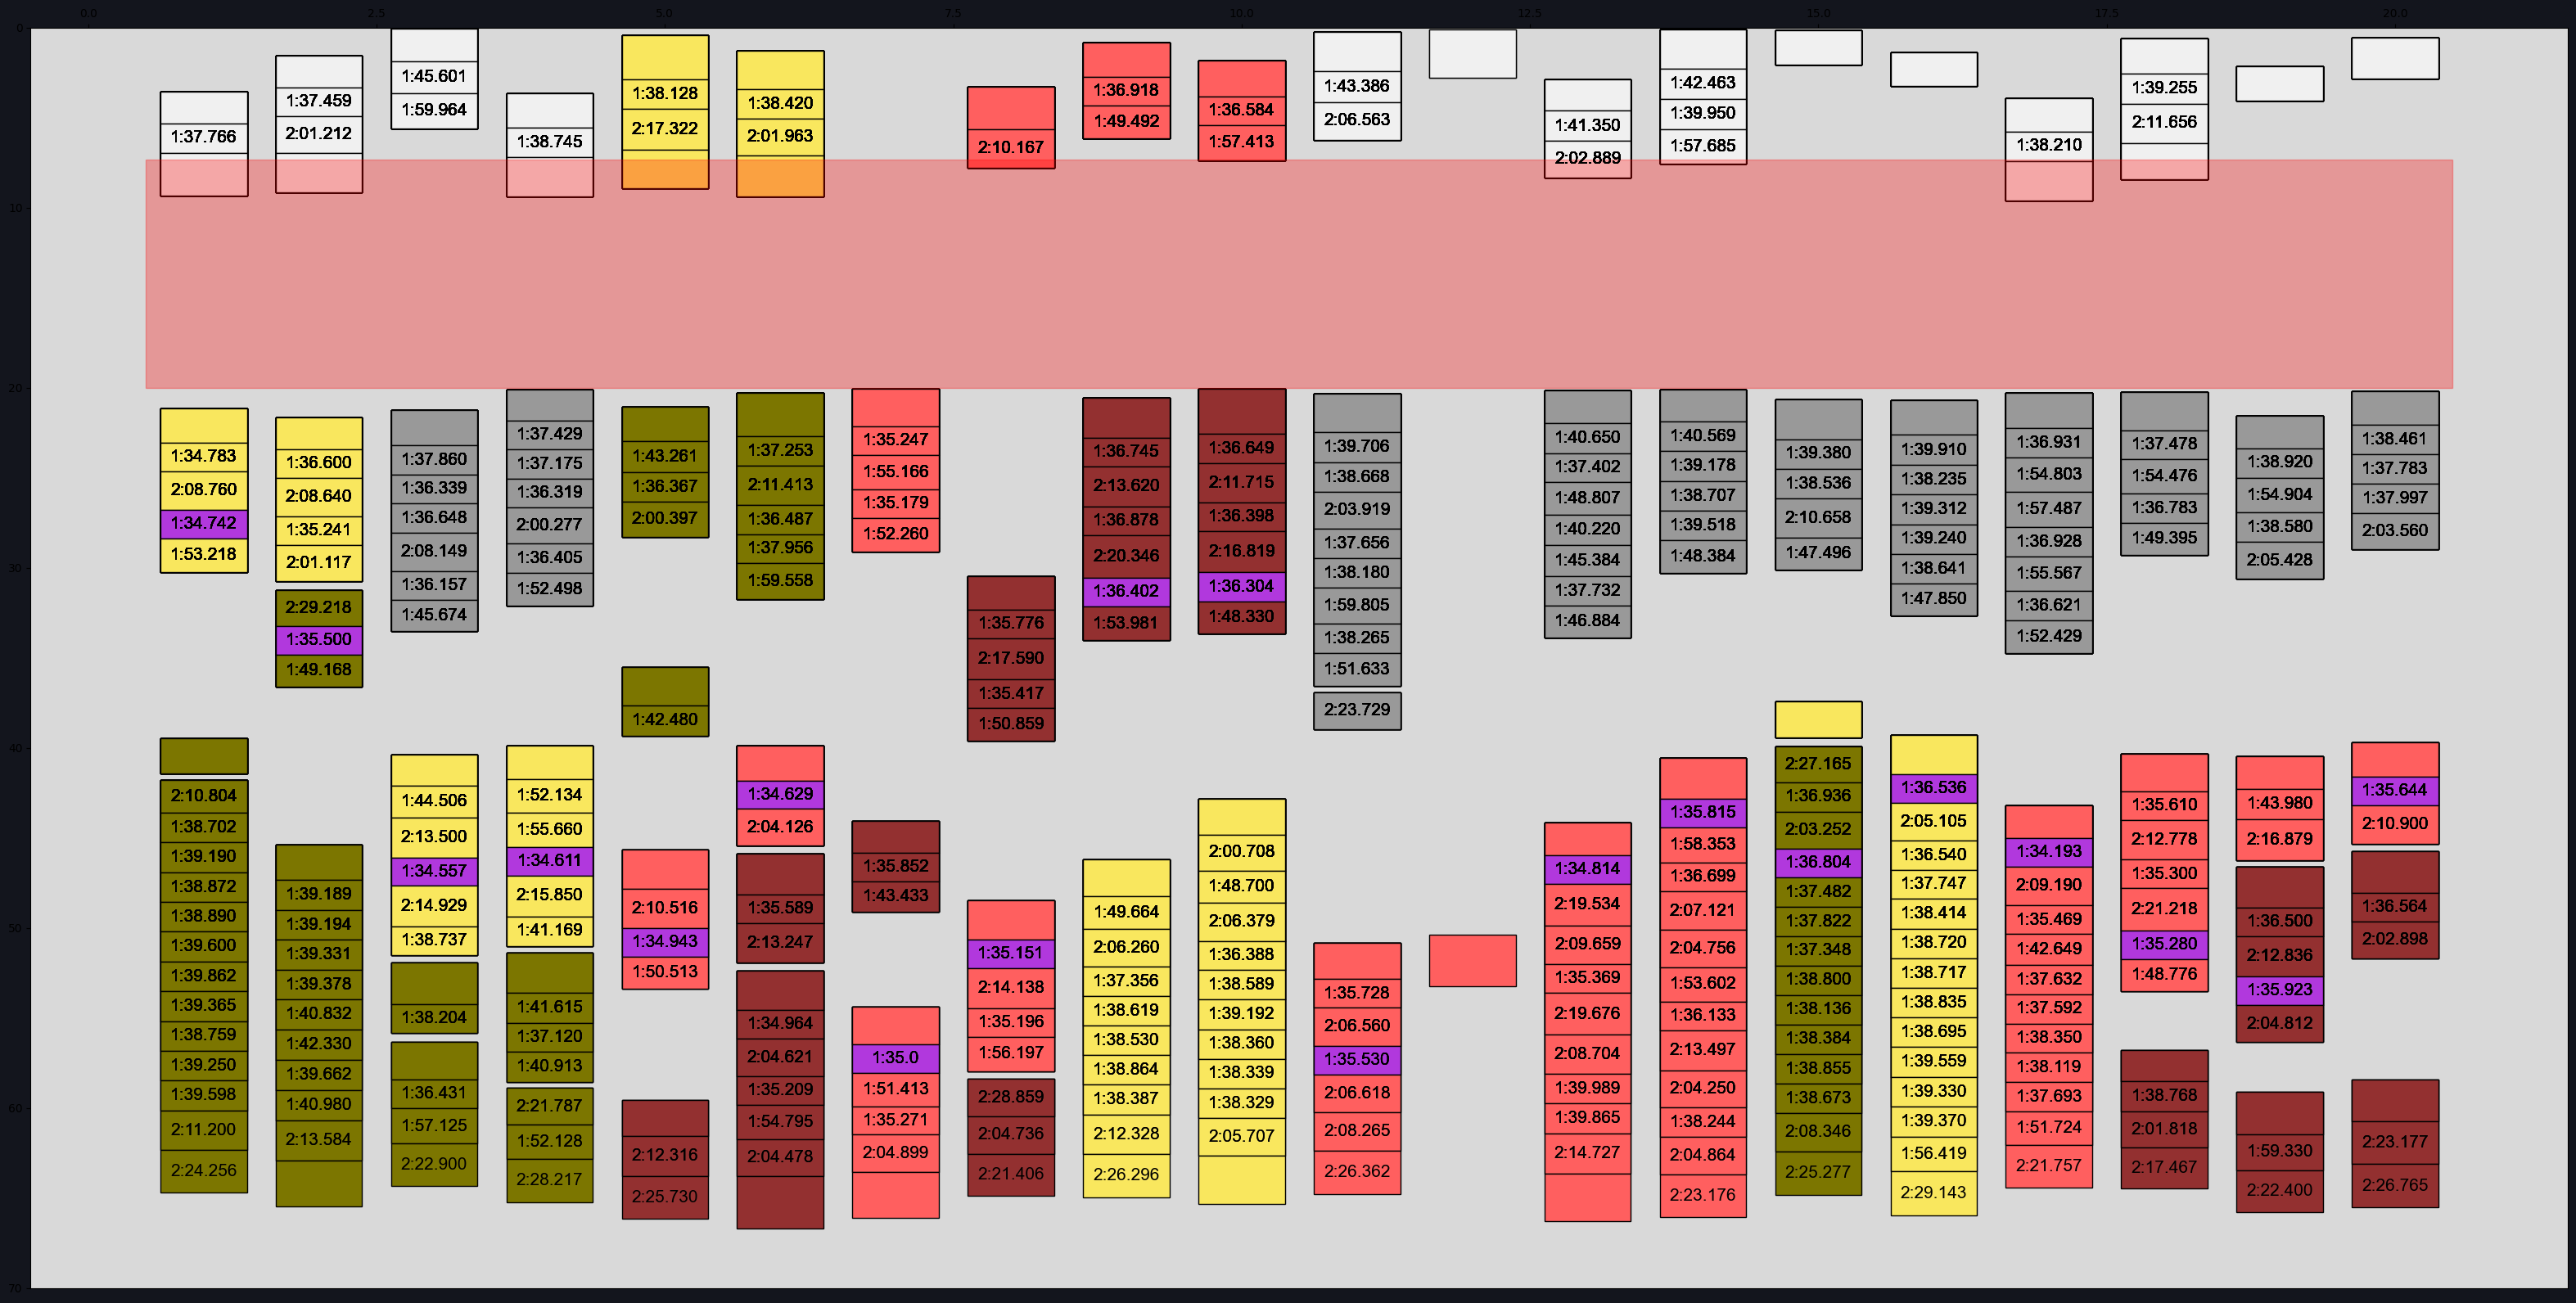

In [8]:
teams = [orderedTeams]
driverCounter = 0
driverFormatList = []

for teamGroup in teams:
    topDrivers = []
    for team in teamGroup:
        for id in teamDict[team]:
            topDrivers.append(id)
    driverFormatList.append(topDrivers)

for topDrivers in driverFormatList:
    plt.rcParams["figure.figsize"] = [40,20] #[40,20] for 10 teams [30,20] for less
    fig, ax = plt.subplots()
    plt.ylim((70,0))
    ax.set_facecolor("#d9d9d9")
    fig.set_facecolor("#13151d")
    title = session.event["EventName"]+" 2022 "+session.name
    for driverId in range(len(topDrivers)):
        driverCounter = driverCounter+1
        #fig.set_facecolor("#"+str(session.get_driver(driverpair[driverId]).TeamColor))
        singleDriverDataFrame = lapsDataFrame[lapsDataFrame["DriverNumber"]==topDrivers[driverId]]
        oldColumns = singleDriverDataFrame.columns.to_list()
        usefulColumns = ['DriverNumber','LapTime','CorrectedPitOutTime','CorrectedTime','CorrectedPitInTime','IsPersonalBest','Compound','FreshTyre','Team']
        for x in oldColumns:
            if x not in usefulColumns:
                del singleDriverDataFrame[x]

        tyreColor = []
        rectangleStart = []
        rectangleStop = []
        lapTimes = []
        for i in range(len(singleDriverDataFrame["CorrectedPitOutTime"].to_list())):
            #tyre coloring
            if singleDriverDataFrame["IsPersonalBest"].to_list()[i]:
                tyreColor.append("PersonalBest")
            else:
                tyreString = ""
                if singleDriverDataFrame["FreshTyre"].to_list()[i]:
                    tyreString = "Fresh"
                else:
                    tyreString = "Used"
                tyreString = tyreString + singleDriverDataFrame["Compound"].to_list()[i]
                tyreColor.append(tyreString)
            #start of rectangle
            if pd.isnull(singleDriverDataFrame["CorrectedPitOutTime"].to_list()[i]):
                rectangleStart.append((singleDriverDataFrame["CorrectedTime"].to_list()[i-1].seconds+singleDriverDataFrame["CorrectedTime"].to_list()[i-1].microseconds/1000000)/60)
            else:
                rectangleStart.append((singleDriverDataFrame["CorrectedPitOutTime"].to_list()[i].seconds+singleDriverDataFrame["CorrectedPitOutTime"].to_list()[i].microseconds/1000000)/60)
            #end of rectangle
            if pd.isnull(singleDriverDataFrame["CorrectedPitInTime"].to_list()[i]):
                rectangleStop.append((singleDriverDataFrame["CorrectedTime"].to_list()[i].seconds+singleDriverDataFrame["CorrectedTime"].to_list()[i].microseconds/1000000)/60)
            else:
                rectangleStop.append((singleDriverDataFrame["CorrectedPitInTime"].to_list()[i].seconds+singleDriverDataFrame["CorrectedPitInTime"].to_list()[i].microseconds/1000000)/60)
            if pd.isnull(singleDriverDataFrame["LapTime"].to_list()[i]):
                lapTimes.append("")
            else:
                if len(str(singleDriverDataFrame["LapTime"].to_list()[i].seconds%60))==2:
                    correctSeconds = str(singleDriverDataFrame["LapTime"].to_list()[i].seconds%60)
                else:
                    correctSeconds = "0"+str(singleDriverDataFrame["LapTime"].to_list()[i].seconds%60)
                lapTime = str(singleDriverDataFrame["LapTime"].to_list()[i].seconds//60)+":"+correctSeconds+"."+str(singleDriverDataFrame["LapTime"].to_list()[i].microseconds)[0:3]
                lapTimes.append(lapTime)
            #plt.bar(driverId, 70, 1, 0, color = "#"+str(session.get_driver(session.drivers[driverId])["TeamColor"].upper()), alpha = 0.5)
            for x in range(len(lapTimes)):
                plt.bar(driverCounter,rectangleStop[x]-rectangleStart[x],0.75,rectangleStart[x], color=compoundColors[tyreColor[x]], edgecolor = "black")
                plt.text(driverCounter,rectangleStop[x]-(rectangleStop[x]-rectangleStart[x])/2,lapTimes[x],fontsize = 15,verticalalignment='center',horizontalalignment='center',fontfamily='Arial')
            #plt.text() fontsize 15 short session 12 long
    ax.xaxis.tick_top()
    for r in range(len(redFlagBeginnings)):
        end = redFlagEndings[r]
        begin = redFlagBeginnings[r]
        rect = plt.Rectangle((0.5,end),driverCounter,begin-end,color = "r", alpha = 0.3)
        ax.add_patch(rect)
    plt.savefig(title+".png")


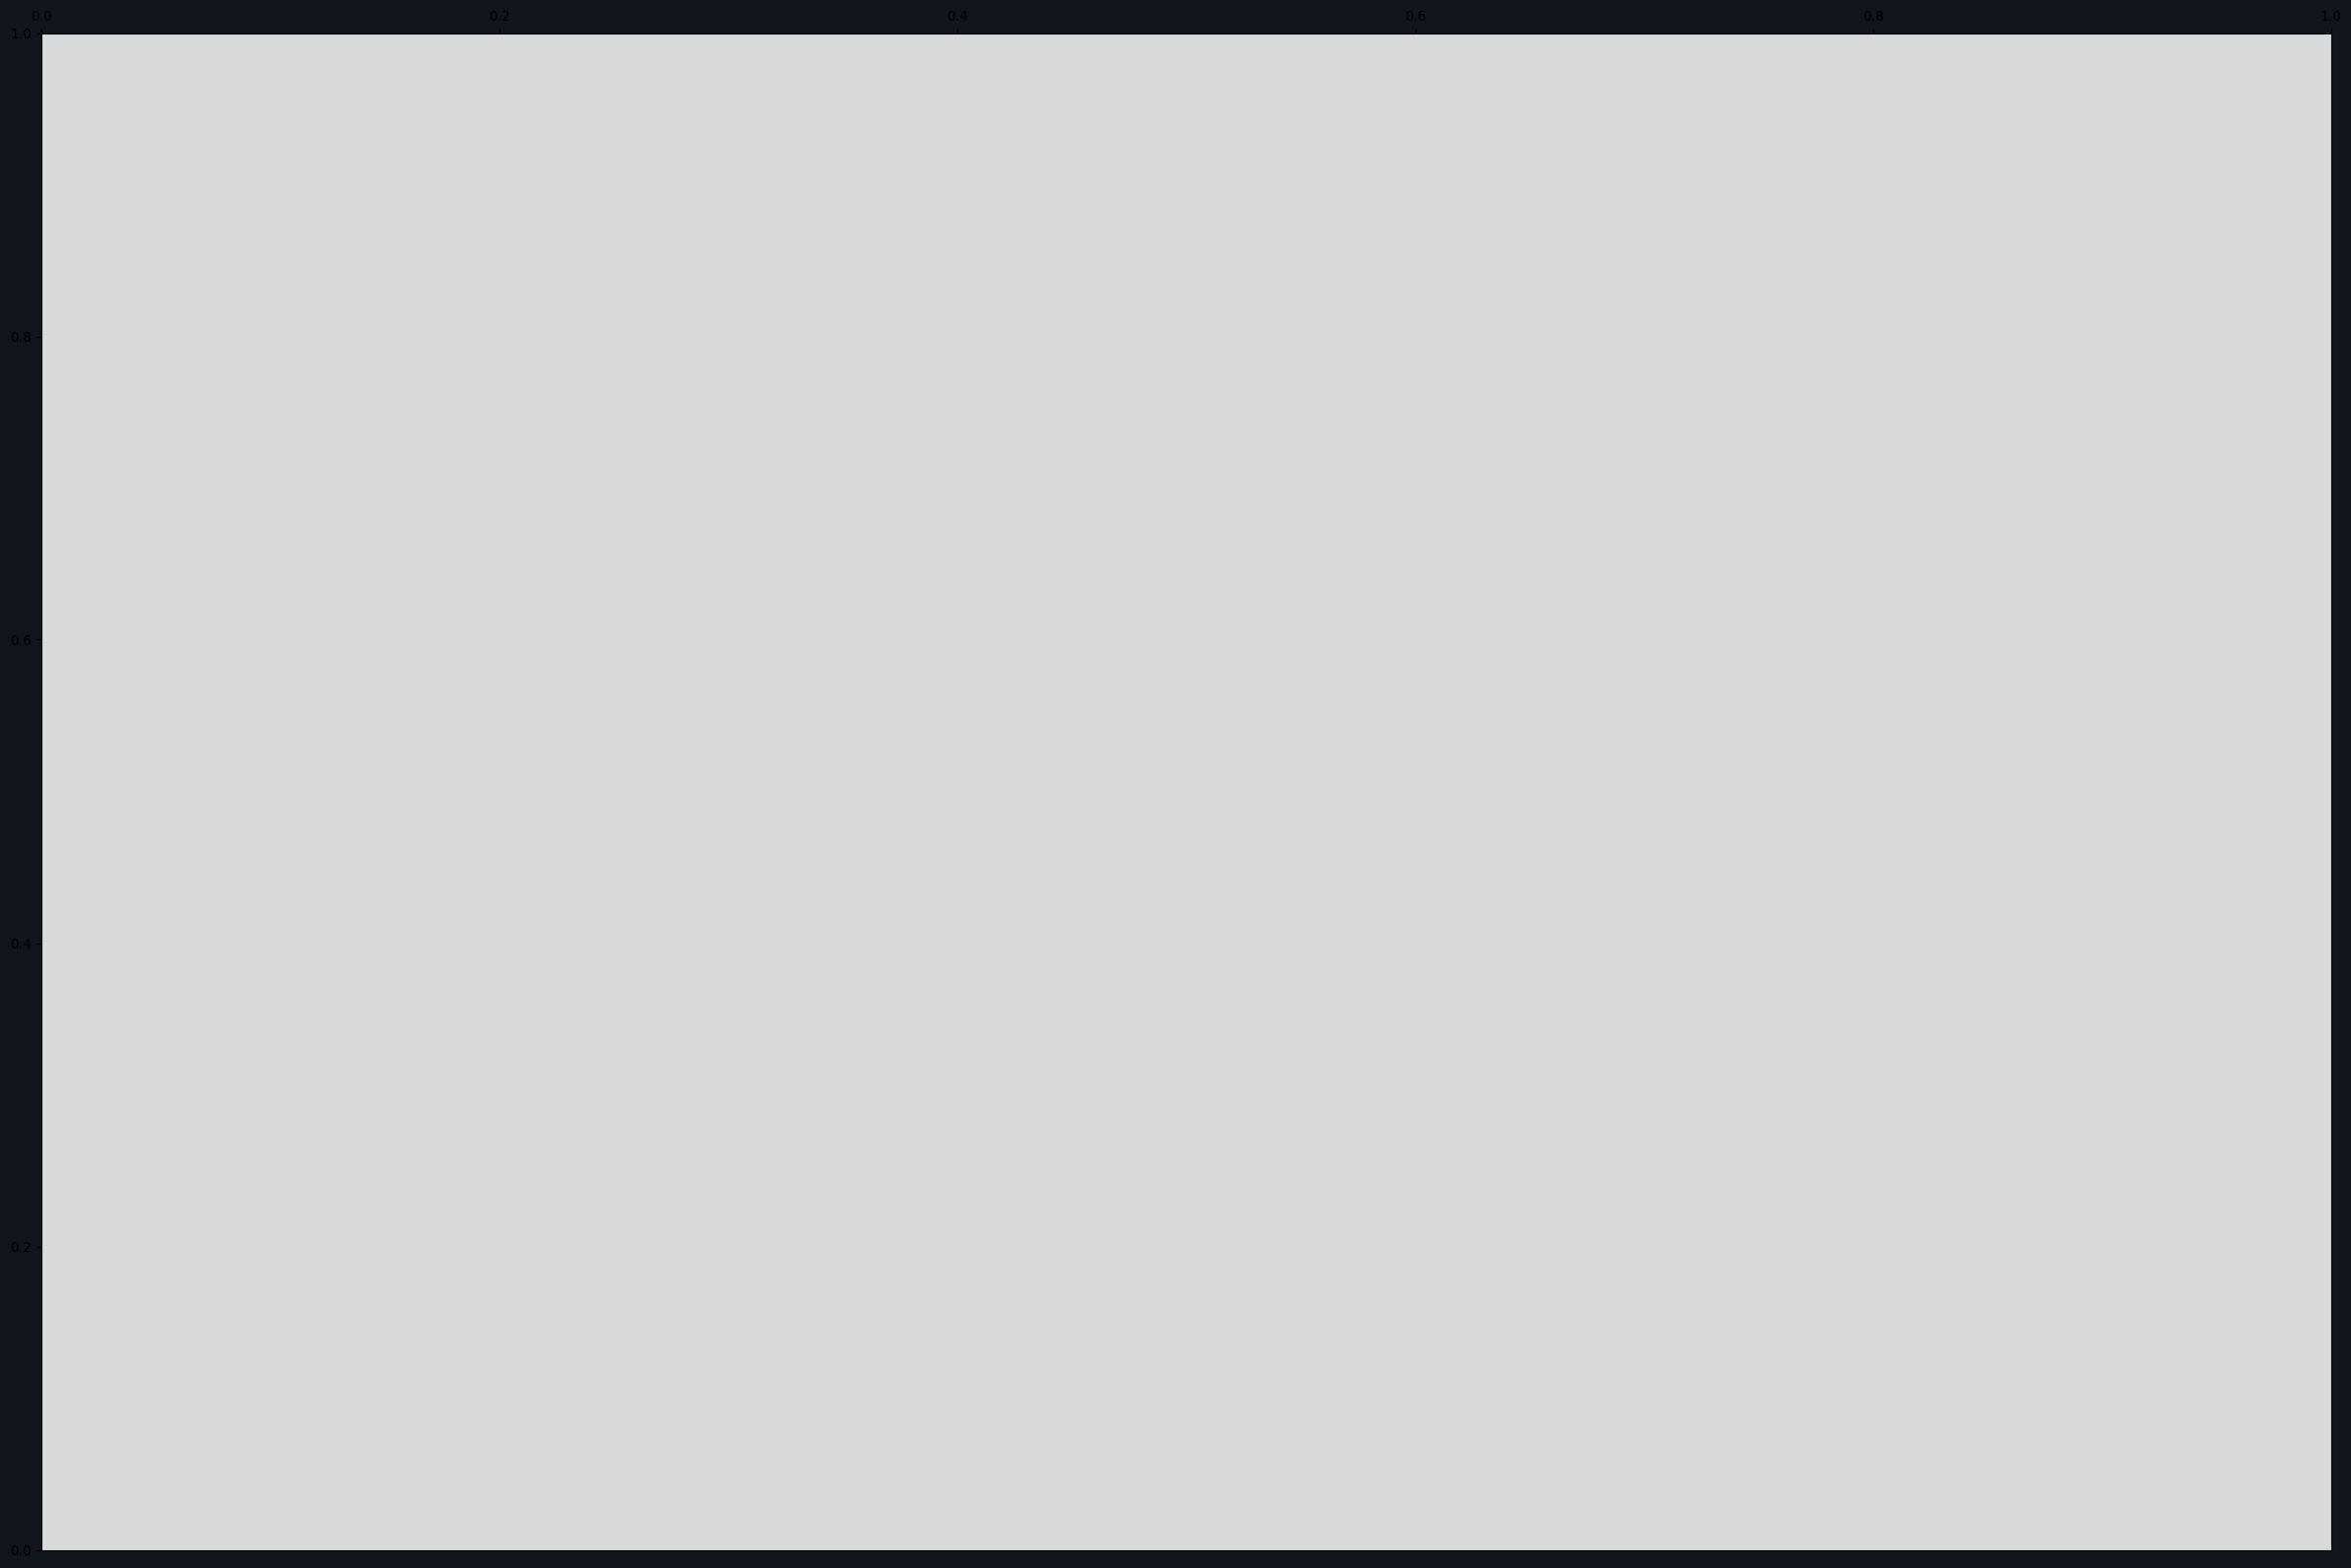

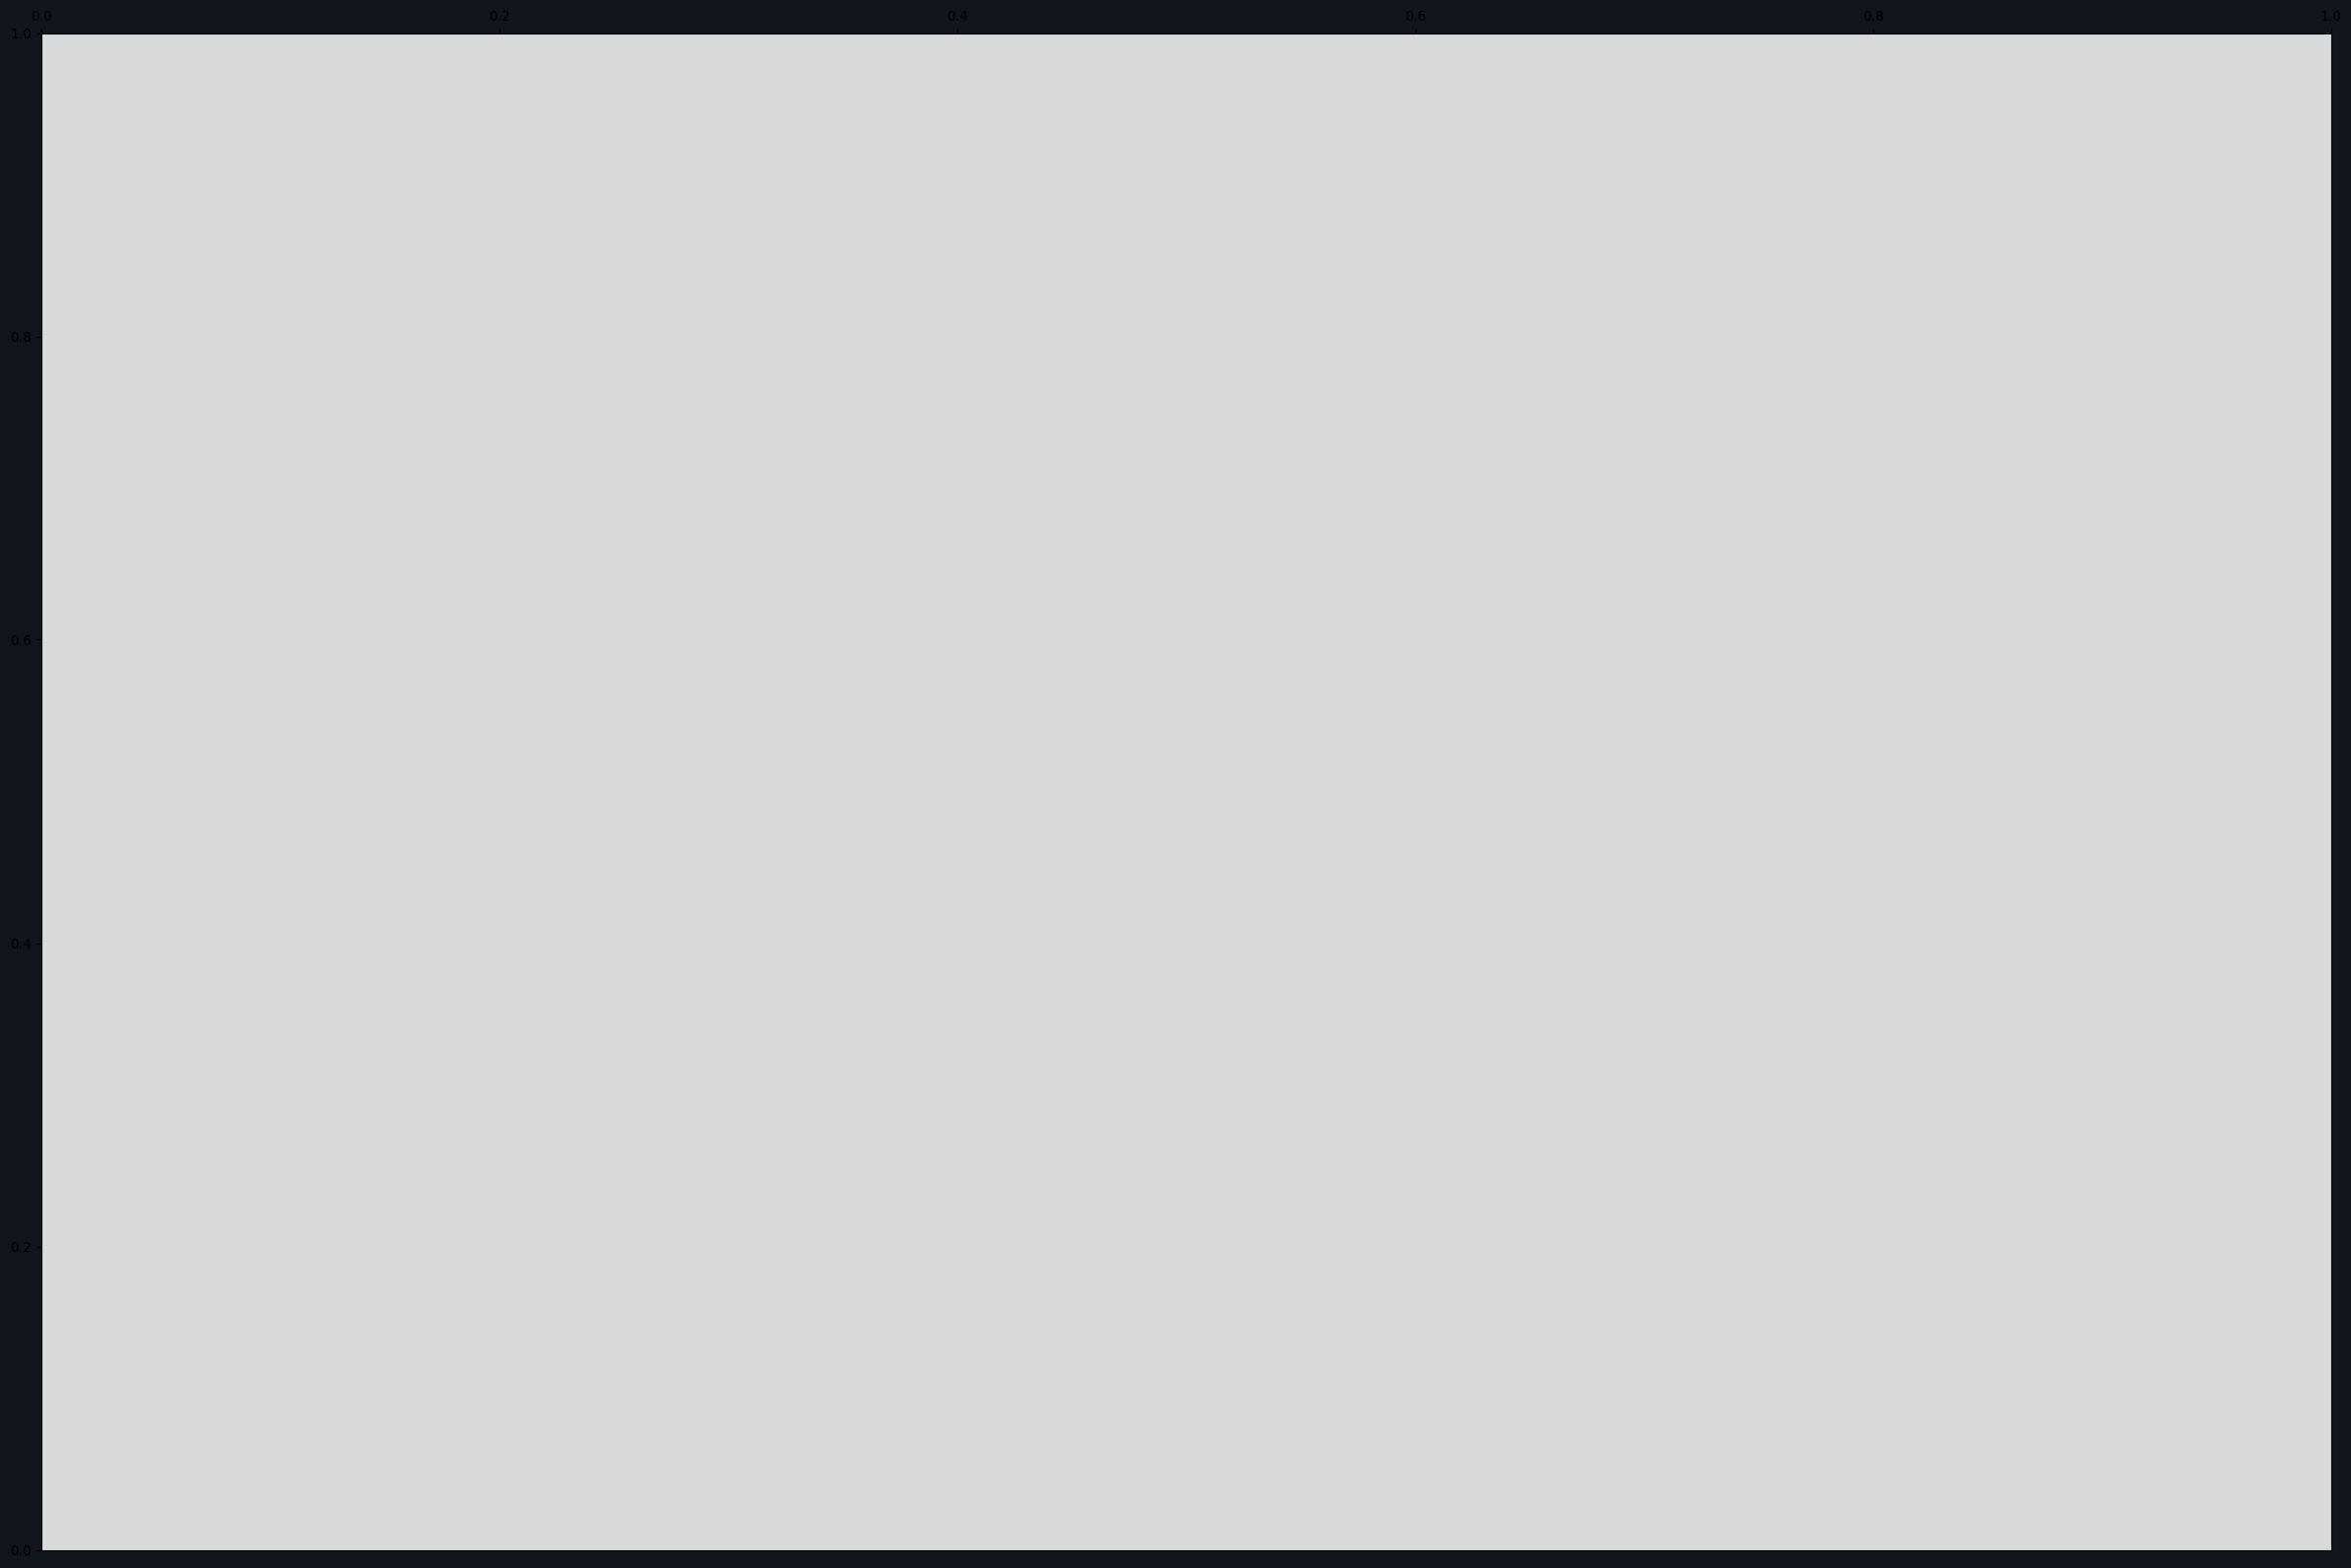

In [9]:

#teams = [orderedTeams[0:3],orderedTeams[3:7],orderedTeams[7:10]]
teams = [orderedTeams[0:5], orderedTeams[5:10]]
#teams = [orderedTeams]

driverFormatList = []

for teamGroup in teams:
    topDrivers = []
    for team in teamGroup:
        for id in teamDict[team]:
            topDrivers.append(id)
    driverFormatList.append(topDrivers)

for topDrivers in driverFormatList:
    plt.rcParams["figure.figsize"] = [30,20] #[40,20] for 10 teams [30,20] for less
    fig, ax = plt.subplots()
    plt.ylim((70,0))
    ax.set_facecolor("#d9d9d9")
    fig.set_facecolor("#13151d")
    title = session.event["EventName"]+" 2022 "+session.name
    title = topDrivers[0] + " " + title
    driverCounter = 0
    for driverId in range(len(topDrivers)):
        driverCounter = driverCounter+1
        #fig.set_facecolor("#"+str(session.get_driver(driverpair[driverId]).TeamColor))
        singleDriverDataFrame = lapsDataFrame[lapsDataFrame["DriverNumber"]==topDrivers[driverId]]
        oldColumns = singleDriverDataFrame.columns.to_list()
        usefulColumns = ['DriverNumber','LapTime','CorrectedPitOutTime','CorrectedTime','CorrectedPitInTime','IsPersonalBest','Compound','FreshTyre','Team']
        for x in oldColumns:
            if x not in usefulColumns:
                del singleDriverDataFrame[x]

        tyreColor = []
        rectangleStart = []
        rectangleStop = []
        lapTimes = []
        for i in range(len(singleDriverDataFrame["CorrectedPitOutTime"].to_list())):
            #tyre coloring
            if singleDriverDataFrame["IsPersonalBest"].to_list()[i]:
                tyreColor.append("PersonalBest")
            else:
                tyreString = ""
                if singleDriverDataFrame["FreshTyre"].to_list()[i]:
                    tyreString = "Fresh"
                else:
                    tyreString = "Used"
                tyreString = tyreString + singleDriverDataFrame["Compound"].to_list()[i]
                tyreColor.append(tyreString)
            #start of rectangle
            if pd.isnull(singleDriverDataFrame["CorrectedPitOutTime"].to_list()[i]):
                rectangleStart.append((singleDriverDataFrame["CorrectedTime"].to_list()[i-1].seconds+singleDriverDataFrame["CorrectedTime"].to_list()[i-1].microseconds/1000000)/60)
            else:
                rectangleStart.append((singleDriverDataFrame["CorrectedPitOutTime"].to_list()[i].seconds+singleDriverDataFrame["CorrectedPitOutTime"].to_list()[i].microseconds/1000000)/60)
            #end of rectangle
            if pd.isnull(singleDriverDataFrame["CorrectedPitInTime"].to_list()[i]):
                rectangleStop.append((singleDriverDataFrame["CorrectedTime"].to_list()[i].seconds+singleDriverDataFrame["CorrectedTime"].to_list()[i].microseconds/1000000)/60)
            else:
                rectangleStop.append((singleDriverDataFrame["CorrectedPitInTime"].to_list()[i].seconds+singleDriverDataFrame["CorrectedPitInTime"].to_list()[i].microseconds/1000000)/60)
            if pd.isnull(singleDriverDataFrame["LapTime"].to_list()[i]):
                lapTimes.append("")
            else:
                if len(str(singleDriverDataFrame["LapTime"].to_list()[i].seconds%60))==2:
                    correctSeconds = str(singleDriverDataFrame["LapTime"].to_list()[i].seconds%60)
                else:
                    correctSeconds = "0"+str(singleDriverDataFrame["LapTime"].to_list()[i].seconds%60)
                lapTime = str(singleDriverDataFrame["LapTime"].to_list()[i].seconds//60)+":"+correctSeconds+"."+str(singleDriverDataFrame["LapTime"].to_list()[i].microseconds)[0:3]
                lapTimes.append(lapTime)
            #plt.bar(driverId, 70, 1, 0, color = "#"+str(session.get_driver(session.drivers[driverId])["TeamColor"].upper()), alpha = 0.5)
            for x in range(len(lapTimes)):
                plt.bar(driverCounter,rectangleStop[x]-rectangleStart[x],0.75,rectangleStart[x], color=compoundColors[tyreColor[x]], edgecolor = "black")
                plt.text(driverCounter,rectangleStop[x]-(rectangleStop[x]-rectangleStart[x])/2,lapTimes[x],fontsize = 15,verticalalignment='center',horizontalalignment='center',fontfamily='Arial')
            #plt.text() fontsize 15 short session 12 long
    ax.xaxis.tick_top()
    for r in range(len(redFlagBeginnings)):
        end = redFlagEndings[r]
        begin = redFlagBeginnings[r]
        rect = plt.Rectangle((0.5,end),driverCounter,begin-end,color = "r", alpha = 0.3)
        ax.add_patch(rect)
    plt.savefig(title+".png")
    plt.cla()


In [ ]:
#style guide
#driver surnames: bahnschrift bold 25 white
#team logos 100x100
#driver pics 125x125
#https://www.formula1.com/en/teams.html